# Final Project
**PH 336**  
Nick Ball, Katie Whiple, Rachel EberNERD

*Z-Score:*
$$
Z = \frac{\bar{x_{1}}+\bar{x_{2}}}{\sqrt{\frac{s^{2}_{1}}{N_{1}} + \frac{s^{2}_{2}}{N_{2}}}}
$$


*$\chi^{2}$ Function:*
$$
\chi^{2} = \sum_{i}\frac{(y_{i} - y(h_{i}))^{2}}{\sigma ^{2}}
$$

*Correlation Coefficient:*
$$
r = \frac{\vec{A}\vec{B}}{|A||B|}
$$

*Potential Model:*
$$
R(h) = R_{1}exp[(-h1 - h)/H]
$$

In [1]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import csv

### Analysis Equations

In [ ]:
def mean(x_array):
    N = len(x_array)
    return sum(x_array)/N

def stdev(x_array):
    x_mean = mean(x_array)
    stdev_x = 0
    N = len(x_array)
    for x in x_array:
        stdev_x += (x-x_mean)**2
    return np.sqrt((stdev_x)/(N-1))

def ZScore(x1_array,x2_array):
    #Calculate the number of values in both arrays
    N1 = len(x1_array)
    N2 = len(x2_array)

    #Calculate the mean of both arrays
    x1_mean = mean(x1_array)
    x2_mean = mean(x2_array)

    #Calculate the Stdev of both arrays
    stdev_x1 = stdev(x1_array)
    stdev_x2 = stdev(x2_array)

    #Calculate and return our Z-Score
    return (x1_mean - x2_mean)/(np.sqrt((stdev_x1*stdev_x1/N1) + (stdev_x2 * stdev_x2/N2)))

def correlation_coefficient(x1_array,x2_array):
    #Define A and B
    A = x1_array - mean(x1_array)
    B = x2_array - mean(x2_array)

    #Find our magnitudes for A and B
    Amag = np.linalg.norm(A)
    Bmag = np.linalg.norm(B)

    #Calculate and return our correlation coefficient
    r = A@B/(Amag*Bmag)
    return r

def Chi_sqrd(x1_array,x2_array,sigma):
    # Calculate our Chi squared value
    chi_sqrd = sum((x1_array-x2_array)*(x1_array-x2_array)/sigma/sigma)
    return chi_sqrd


In [10]:
class location_data:
    def __init__(self,location,data,location_type = None):
        self.location = location
        self.data = data
        self.location_type = location_type

    def display_location(self):
        print(self.location, self.location_type)


class comparison_data:
    def __init__(self,location_data_1,location_data_2,Z_score,Chi,r):
        self.location_data_1 = location_data_1
        self.location_data_2 = location_data_2
        self.Z_score = Z_score
        self.Chi = Chi
        self.r = r

    def export_format(self):
        export_array = [
            [f"{self.location_data_1.location}",f"{self.location_data_2.location}"],
            ["=====================","====================="],
            ["Test","Value"],
            ["---------------------","---------------------"],
            ["Z-Score",f"{self.Z_score:.2f}"],
            ["Chi Sqrd",f"{self.Chi:.2f}"],
            ["Correlation Coefficient", f"{self.r}"],
            ["---------------------","---------------------"],
            ["",""]
            ]
        return export_array
        

### Analysis of CPM Between Buildings

In [24]:
def read_geiger_data(filename):
    """This function reads the geiger counter data for the buildings 
    and parses them into a compound list of location data.
    Params: 
        filename: string
    Return:
        location_data_list: compound list of location_data class objects
    """
    #Create new blank lists
    location_data_list = []
    index_list = []
    compound_list = []

    #Open csv file
    with open(filename, "rt") as csv_file:
        reader = csv.reader(csv_file)
        LOCATION_INDEX = 0
        EVENT_INDEX = 1
        COUNT_RATE_INDEX = 3

        #Skip the first line
        next(reader)

        #Generate a list of position indecis to use for main loop
        for i,row in enumerate(reader):

            #Log the index location of the location_name
            if (row[EVENT_INDEX] != "Current data values"):
                index_list.append(i)
                compound_list.append(row[LOCATION_INDEX])
            else:
                #Take string from CPM and remove the CPM
                CPM_data = row[COUNT_RATE_INDEX].split(" ")[0]
                compound_list.append(CPM_data)

        #Define the bounds of the array index
        ARRAY_START_INDEX = 1
        ARRAY_END_INDEX = index_list[1]-1

        #Loop through each set and parse data into respective
        #class structure
        for index in index_list:
            
            #First line will always be location name
            location_name = compound_list[index]
            
            #Pull all data between indeces into a numpy float array
            geiger_data = np.array(compound_list[index+ARRAY_START_INDEX:index+ARRAY_END_INDEX]).astype(float)
            

            #Create a new location data object and append to array
            local_data = location_data(location_name,geiger_data)
            location_data_list.append(local_data)

    return location_data_list
        
def compare_data(location_data_list): #Ignore for now
    """Function takes the list of location_data and parses through 
    and compares it against the other values.
    Parameters:
        List of location_data objects
    Returns:
        uhhhhhhhhh...... 
    """
    compared_data_list = []
    #Another loop function, this time not double counting units
    for i in range(len(location_data_list)):
        x1_array = location_data_list[i].data
        for j in range(i,len(location_data_list)):
            x2_array = location_data_list[j].data
            sigma = np.sqrt(x1_array*x2_array)

            z_score = ZScore(x1_array,x2_array)
            chi_sqrd = Chi_sqrd(x1_array,x2_array,sigma)   #NEED TO FIX SIGMA!!!
            r = correlation_coefficient(x1_array,x2_array)

            compared_data = comparison_data(location_data_list[i],location_data_list[j],z_score,chi_sqrd,r)
            compared_data_list.append(compared_data)

    return compared_data_list

def export_data_to_csv(export_file,data_list):
    #Clear the old file
    clear_list = []
    df = pd.DataFrame(clear_list)
    pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='w')

    #Convert list of lists to Pandas dataframe
    for export_data in data_list:
        df = pd.DataFrame(export_data.export_format())
        pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='a')

def main1():
    #Read all location data from file and put into a list of location data
    location_data_list = read_geiger_data("random_geiger_data_1.csv")

    #Compare all the location data
    compared_data_list = compare_data(location_data_list)

    #Export our data to 
    export_data_to_csv("compared_data.csv",compared_data_list)

    return

main1()

ROM 2nd floor
['485', '502', '472', '418', '404', '419', '452', '444', '474']
ROM 1st Floor
['756', '691', '721', '688', '685', '685', '656', '632', '668']
ROM Basement
['791', '748', '791', '759', '779', '554', '547', '552', '639']
Stadium Top
['182', '166', '178', '201', '189', '197', '171', '192', '164']
Stadium Middle
['218', '225', '251', '223', '244', '248', '233', '228', '222']
Stadium Base
['354', '348', '346', '328', '341', '344', '306', '334', '336']
Ricks 2
['340', '322', '300', '319', '309', '305', '315', '307', '319']
Ricks 1
['401', '399', '404', '355', '392', '386', '392', '373', '365']
Ricks Basement
['396', '459', '416', '418', '422', '448', '424', '408', '414']


c:\Users\slick\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


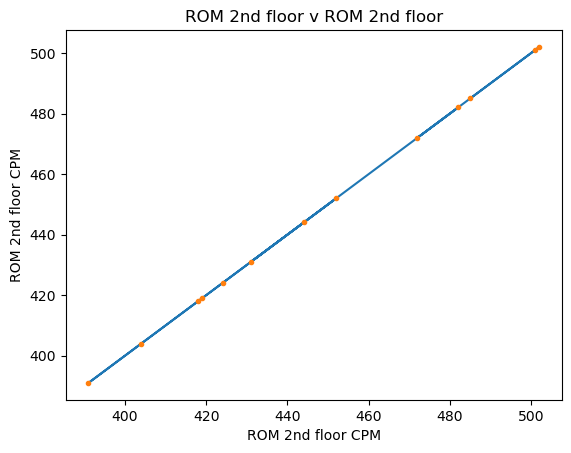

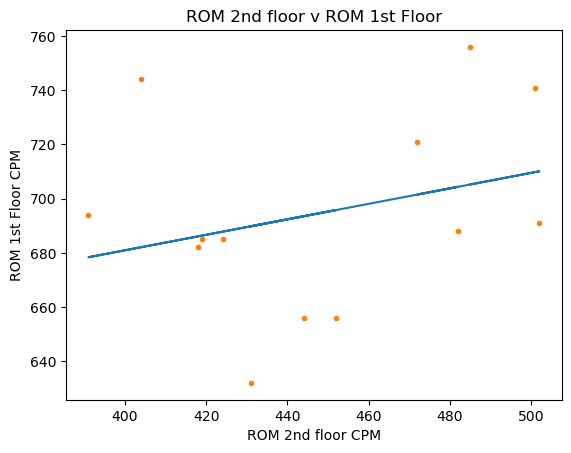

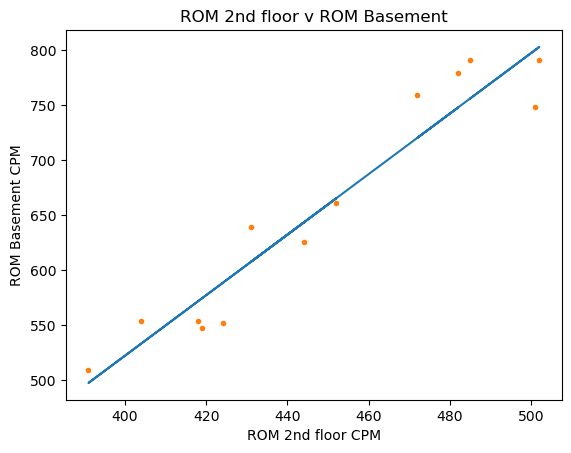

ValueError: array must not contain infs or NaNs

In [13]:
#Open and read from file
def read_from_file(file_name):
    """Function reads our data from our file and transforms it into
    a numpy array, which we return.
    Parameters: 
      file_name
    Return: 
      file_data as a numpy array
    """
    data = pd.read_csv(file_name,encoding='unicode_escape')
    return data

#Parse through and return list of location data
def parse_file_data(file_data):
    """ Function parses file_data and splits it into classes, then appends
    it to a list.
    Parameters:
        file_data (numpy array)
    Return:
        list of location_data objects
    """
    #Create new blank list
    location_data_list = []

    #Parse through file_data
    index = file_data.index[file_data["Comment"].notna()]

    for idx in index:
        data = []
        location = str(file_data["Real time"][idx])
        location_type = str(file_data["Comment"][idx])

        #Sort through the data and remove the CPM from each
        for strings in np.array(file_data["Count rate"][idx+1:idx+14]).astype(str):
            data.append(strings.split(" ")[0])
        
        #Convert the data to a nparray
        data = np.array(data).astype(float)

        #Create a new location data object and append to array
        local_data = location_data(location,data,location_type)
        location_data_list.append(local_data)

    return location_data_list

def compare_data(location_data_list): #Ignore for now
    """Function takes the list of location_data and parses through 
    and compares it against the other values.
    Parameters:
        List of location_data objects
    Returns:
        uhhhhhhhhh...... 
    """
    compared_data_list = []
    #Another loop function, this time not double counting units
    for i in range(len(location_data_list)):
        x1_array = location_data_list[i].data
        for j in range(i,len(location_data_list)):
            x2_array = location_data_list[j].data
            sigma = np.sqrt(x1_array*x2_array)

            z_score = ZScore(x1_array,x2_array)
            chi_sqrd = Chi_sqrd(x1_array,x2_array,sigma)   #NEED TO FIX SIGMA!!!
            r = correlation_coefficient(x1_array,x2_array)

            #plt.plot(x1_array,x2_array,'.')
            #plt.show()

            compared_data = comparison_data(location_data_list[i],location_data_list[j],z_score,chi_sqrd,r)
            compared_data_list.append(compared_data)

    return compared_data_list
    
def export_data_to_csv(export_file,data_list):
    #Clear the old file
    clear_list = []
    df = pd.DataFrame(clear_list)
    pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='w')

    #Convert list of lists to Pandas dataframe
    for export_data in data_list:
        df = pd.DataFrame(export_data.export_format())
        pd.DataFrame.to_csv(df,export_file,header= False,index=False,mode='a')

def mean(x_array):
    N = len(x_array)
    return sum(x_array)/N

def stdev(x_array):
    x_mean = mean(x_array)
    stdev_x = 0
    N = len(x_array)
    for x in x_array:
        stdev_x += (x-x_mean)**2
    return np.sqrt((stdev_x)/(N-1))

def ZScore(x1_array,x2_array):
    #Calculate the number of values in both arrays
    N1 = len(x1_array)
    N2 = len(x2_array)

    #Calculate the mean of both arrays
    x1_mean = mean(x1_array)
    x2_mean = mean(x2_array)

    #Calculate the Stdev of both arrays
    stdev_x1 = stdev(x1_array)
    stdev_x2 = stdev(x2_array)

    #Calculate and return our Z-Score
    return (x1_mean - x2_mean)/(np.sqrt((stdev_x1*stdev_x1/N1) + (stdev_x2 * stdev_x2/N2)))

def correlation_coefficient(x1_array,x2_array):
    #Define A and B
    A = x1_array - mean(x1_array)
    B = x2_array - mean(x2_array)

    #Find our magnitudes for A and B
    Amag = np.linalg.norm(A)
    Bmag = np.linalg.norm(B)

    #Calculate and return our correlation coefficient
    r = A@B/(Amag*Bmag)
    return r

def Chi_sqrd(x1_array,x2_array,sigma):
    # Calculate our Chi squared value
    chi_sqrd = sum((x1_array-x2_array)*(x1_array-x2_array)/sigma/sigma)
    return chi_sqrd

def y(x,b,m):
    return m*x + b

def PlotData(compared_data_list):
    for compared_data in compared_data_list:
        x1_array = compared_data.location_data_1.data
        x2_array = compared_data.location_data_2.data


        coeff,discard = curve_fit(y,x1_array,x2_array)
        m = coeff[0]
        b = coeff[1]
        y_points = []
        for x in x1_array:
            y_points.append(y(x,m,b))

        plt.title(f"{compared_data.location_data_1.location} v {compared_data.location_data_2.location}")
        plt.xlabel(f"{compared_data.location_data_1.location} CPM")
        plt.ylabel(f"{compared_data.location_data_2.location} CPM")
        plt.plot(x1_array,y_points)
        plt.plot(x1_array,x2_array,'.')
        plt.show()

def main():
    #Pull data from file and parse it into classes
    file_name = "PH 336 SDL ROM 2 2024-03-20.csv"
    file_data = read_from_file(file_name)
    location_data_list = parse_file_data(file_data)
    compared_data_list = compare_data(location_data_list)

    PlotData(compared_data_list)

    #display_data()
    export_data_to_csv("compared_data.csv",compared_data_list)

main()

### Altitude Comparison

In [2]:
#Import libraries
import csv

#Read in data from geiger counter
def read_alt_geiger_data(filename):
    """Read the contents of a CSV file into a compound
    list and return the list. Each element in the
    compound list will be a small list that contains
    the values from one row of the CSV file.

    Parameter filename: the name of the CSV file to read
    Return: a list of lists that contain strings
    """
    DATE_TIME_INDEX = 0
    EVENT_INDEX = 1
    COUNT_RATE_INDEX = 3


    #Create empty list for our filedata
    compound_list = []

    #Open our file and read everything to a reader
    with open(filename, "rt") as csv_file:
        reader = csv.reader(csv_file)

        #Skip the first line
        next(reader)   

        #Parse through file one row at a time
        for row_list in reader:

            #Check to see that the event column has the value "Current data values"
            if row_list[EVENT_INDEX] == "Current data values":
                row = []
                row.append(row_list[DATE_TIME_INDEX])
                row.append(row_list[COUNT_RATE_INDEX])

                compound_list.append(row)
 
    return compound_list


#Parse through our data to remove the date and the cpm from the strings
def parse_geiger_data(compound_list):  
    """Function parses through the compound list and removes the 
    Date and the CPM elements from the list
    
    Parameter: compound list of file_data from read_compound_list
    Return: modified compound list
    """
    DATE_TIME_STRING_INDEX = 0
    TIME_STRING_INDEX = 1
    CPM_STRING_INDEX = 1
    CPM_DATA_INDEX = 0

    modified_compound_list = []

    #Loop through the rows and remove necesary extras
    for row in compound_list:

        #Store full date time string
        date_time_string = row[DATE_TIME_STRING_INDEX]

        #Split string and discard date
        time_string = date_time_string.split("  ")[TIME_STRING_INDEX] #Need to modify so that time is broken up by ":"

        #Replace the '.' in the string with ':'
        time_string.replace(".",":")

        #Store full CPM string
        CPM_string = row[CPM_STRING_INDEX]

        #Split string and discard the CPM
        CPM_data = CPM_string.split(" ")[CPM_DATA_INDEX]

        #Add both to a list and append to our modified compound list
        new_row_list = [time_string,CPM_data]
        modified_compound_list.append(new_row_list)

    return modified_compound_list

def read_altitude_data(filename):
    """Function reads in the file data from the txt file and 
    formats it into a list for later parsing.
    
    Parameters: filename as a string
    Return: compound list of strings
    """
    TIME_INDEX = 0
    ALTITUDE_INDEX = 10

    compound_list = []

    #Open the txt file and read the wanted values form it
    with open(filename, "rt") as text_file:
        
        #Read one line at a time
        for line in text_file:

            #Remove white spacing from the line
            clean_line = line.strip()

            #Split list up based on delimiter
            time_string = clean_line.split(", ")[TIME_INDEX]
            altitude_string = clean_line.split(", ")[ALTITUDE_INDEX]

            #Add both to a list and append to the compound list
            new_line = [time_string,altitude_string]
            compound_list.append(new_line)

    return compound_list


def parse_altitude_list(compound_list):
    """Function parses the compound list of altitude data and removes the ms
    from the time data and the 'Altitude' string from the altitude data
    
    Parameters: compound list of the altitude data
    Returns: modified compound list of usable data
    """
    TIME_INDEX = 0
    ALTITUDE_DATA_INDEX = 1

    modified_compound_list = []

    #Loop through the rows of data and remove necessary items
    for row in compound_list:

        #Remove the miliseconds of the time string
        time_string = row[0].split(".")[TIME_INDEX]

        #Remove the 'Altitude' string from the altitude string
        altitude_data = row[1].split(": ")[ALTITUDE_DATA_INDEX]

        #Add both to a list and append to modified_compound_list
        new_line = [time_string,altitude_data]
        modified_compound_list.append(new_line)
    
    return modified_compound_list
        

compound_geiger_list = read_alt_geiger_data("geiger_altitude_data.csv")
mod_geiger_list = parse_geiger_data(compound_geiger_list)

compound_alt_list = read_altitude_data("GPSLOG24.txt")
mod_alt_list = parse_altitude_list(compound_alt_list)










